In [1]:
import sys
from pathlib import Path
import time
import shap
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix

PROJ_ROOT = Path.cwd().parent
if str(PROJ_ROOT) not in sys.path:
    sys.path.append(str(PROJ_ROOT))

from credit_risk_xai.modeling.train import DEFAULT_PARAMS

from credit_risk_xai.config import FEATURE_CACHE_PATH
from credit_risk_xai.features.engineer import prepare_modeling_data

from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

def plot_calibration_curve(y_true, y_pred_proba, n_bins=10, model_name="Model"):
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_pred_proba, n_bins=n_bins, strategy='uniform'
    )
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=model_name)
    plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration")


    plt.xlabel("Mean predicted probability")
    plt.ylabel("Fraction of positives")
    plt.legend()
    plt.title(f"Calibration Curve - {model_name}")
    plt.show()
    
    # ECE (Expected Calibration Error)
    ece = np.mean(np.abs(fraction_of_positives - mean_predicted_value))
    print(f"ECE: {ece:.4f}")

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load and filter data
MIN_REVENUE_KSEK = 1_000
df = pd.read_parquet(FEATURE_CACHE_PATH)
df = df[(df["ser_aktiv"] == 1) & (df["sme_category"].isin(["Small", "Medium"])) & (df["knc_kncfall"] == 1)]
X, y = prepare_modeling_data(df)

print(f"Features: {X.shape[1]} | Samples: {len(X):,}")
print(f"Target distribution:\n{y.value_counts()}")
print(f"Imbalance: {(y==0).sum()/(y==1).sum():.1f}:1")

Features: 58 | Samples: 316,663
Target distribution:
target_next_year
0    310079
1      6584
Name: count, dtype: Int64
Imbalance: 47.1:1


In [3]:
from credit_risk_xai.features.engineer import prepare_modeling_data
from credit_risk_xai.modeling.train import run_lightgbm_training

X, y = prepare_modeling_data(df)

results = run_lightgbm_training(
    X=X,
    y=y,
    dataset_description="ser_aktiv==1 & SME∈{Small,Medium} & knc_kncfall==1",  # optional note for W&B
    use_wandb=False,
    wandb_project="credit-risk-xai",
    wandb_run_name="lgbm_nested_kfolds_temporal_prune",
)

[50]	training's binary_logloss: 0.0452611	valid_1's binary_logloss: 0.0497081
[100]	training's binary_logloss: 0.0388159	valid_1's binary_logloss: 0.0472924
[150]	training's binary_logloss: 0.0344983	valid_1's binary_logloss: 0.0465979
[200]	training's binary_logloss: 0.0314698	valid_1's binary_logloss: 0.0463583
[250]	training's binary_logloss: 0.0290141	valid_1's binary_logloss: 0.046174
[300]	training's binary_logloss: 0.0269156	valid_1's binary_logloss: 0.0461248
[350]	training's binary_logloss: 0.0250427	valid_1's binary_logloss: 0.0461042
[400]	training's binary_logloss: 0.0233783	valid_1's binary_logloss: 0.0460963
[450]	training's binary_logloss: 0.0217528	valid_1's binary_logloss: 0.0460966


AUC: 0.9517
PR-AUC: 0.6495

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     62016
         1.0       0.93      0.48      0.63      1317

    accuracy                           0.99     63333
   macro avg       0.96      0.74      0.81     63333
weighted avg       0.99      0.99      0.99     63333


Confusion Matrix:
[[61971    45]
 [  689   628]]


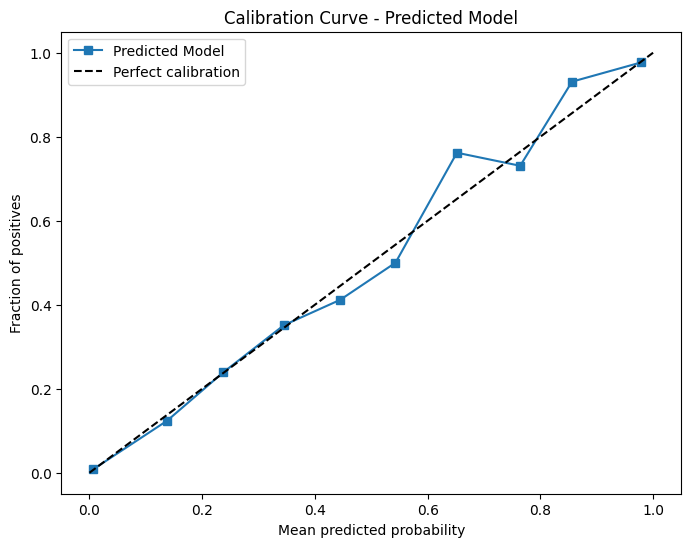

ECE: 0.0319


In [4]:
# Evaluate
model = results["model"]
X_train = results["X_train"]
X_val = results["X_val"]
y_train = results["y_train"]
y_val = results["y_val"]
y_pred_proba = results["y_val_proba"]
y_pred = (y_pred_proba >= 0.5).astype(int)

auc = roc_auc_score(y_val, y_pred_proba)
pr_auc = average_precision_score(y_val, y_pred_proba)

print(f"AUC: {auc:.4f}")
print(f"PR-AUC: {pr_auc:.4f}\n")
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))

plot_calibration_curve(y_val, y_pred_proba, model_name="Predicted Model")

Top Features (by Gain):
                        feature   importance
                        ny_omsf 53707.729404
            event_count_last_5y 41806.689630
                    ny_avkegkap 39027.745316
ratio_ebit_interest_cov_yoy_pct 31443.867623
  years_since_last_credit_event 26368.297023
                       ny_solid 21088.746542
          ratio_dividend_payout 12885.110176
          rr07_rorresul_yoy_pct 11526.158342
             rr01_ntoms_yoy_abs  9834.011846
              ny_solid_yoy_diff  8556.952829
              dpo_days_yoy_diff  8539.616625
                    ny_skuldgrd  7720.190020
           ratio_cash_liquidity  7504.826000
                   br07b_kabasu  6511.928618
           ny_skuldgrd_yoy_diff  5759.568336
                       dpo_days  5206.646808
               equity_to_profit  5193.332246
   ratio_cash_liquidity_yoy_pct  5149.698538
   ratio_cash_liquidity_yoy_abs  4938.178921
                      br10_eksu  4363.084210
                revenue_cagr_3y

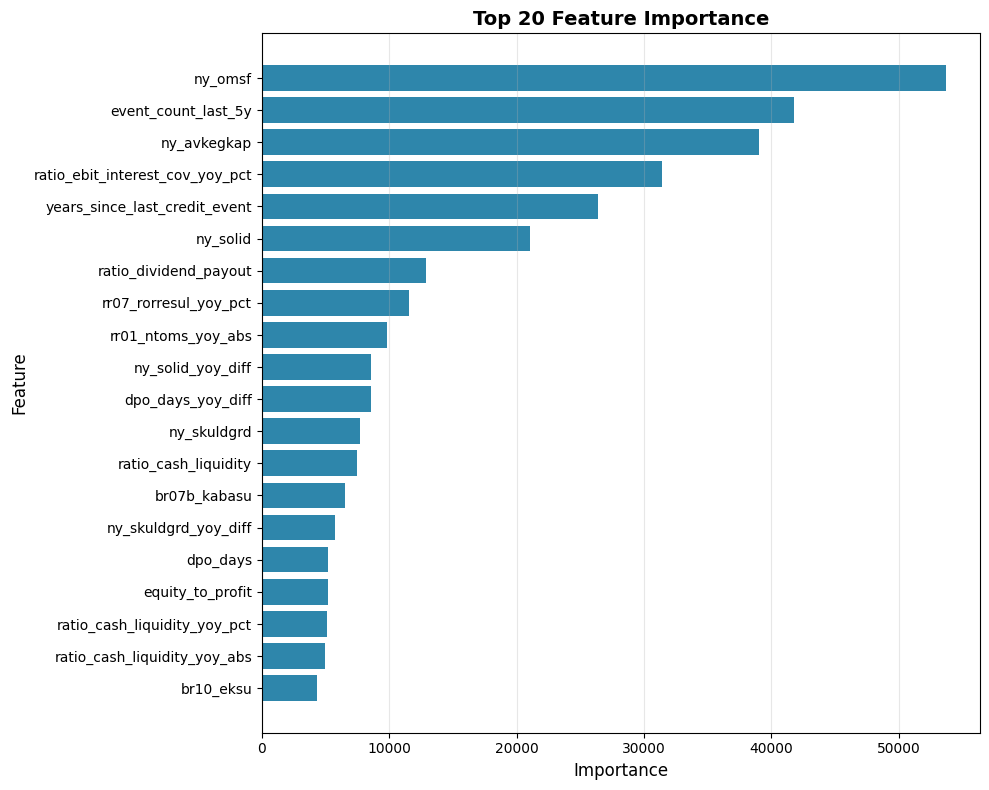


Feature Group Importance Analysis
               group  total_importance  mean_importance  feature_count
               OTHER     193540.073411      6673.795635             29
               TREND      87993.732470      9777.081386              9
              CRISIS      68174.986653     34087.493327              2
               RATIO      48284.009033      4389.455367             11
               MACRO       7284.622097      1456.924419              5
LIQUIDITY_EFFICIENCY       7136.254376      3568.127188              2


In [5]:
# Feature importance analysis
from credit_risk_xai.modeling import get_feature_importance, plot_feature_importance, analyze_feature_groups
from credit_risk_xai.config import (
    RATIO_FEATURE_NAMES, 
    LIQUIDITY_EFFICIENCY_FEATURES, 
    TREND_FEATURE_NAMES, 
    CRISIS_FEATURE_NAMES, 
    MACRO_FEATURE_NAMES
)

# 1. Get LightGBM feature importance (using gain)
importance_df = get_feature_importance(model, X_train, importance_type='gain', top_n=None)
print("Top Features (by Gain):")
print(importance_df.to_string(index=False))

# 2. Visualize feature importance
plot_feature_importance(importance_df, top_n=20, show=True)

# 3. Analyze by feature groups
feature_groups = {
    "RATIO": RATIO_FEATURE_NAMES,
    "LIQUIDITY_EFFICIENCY": LIQUIDITY_EFFICIENCY_FEATURES,
    "TREND": TREND_FEATURE_NAMES,
    "CRISIS": CRISIS_FEATURE_NAMES,
    "MACRO": MACRO_FEATURE_NAMES,
}

group_stats = analyze_feature_groups(model, X_train, feature_groups, importance_type='gain')
print("\n" + "="*80)
print("Feature Group Importance Analysis")
print("="*80)
print(group_stats.to_string(index=False))

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


Top 117 Features (by SHAP):
                        feature  mean_abs_shap
          ratio_dividend_payout       0.564504
           ratio_cash_liquidity       0.237749
                       ny_solid       0.199325
                    company_age       0.192167
                   br07b_kabasu       0.174543
                    ny_avkegkap       0.172900
                    ny_skuldgrd       0.137931
                          ny_rs       0.130905
              dpo_days_yoy_diff       0.127043
                revenue_cagr_3y       0.124815
               equity_to_profit       0.124065
                     ny_kapomsh       0.098496
        inventory_days_yoy_diff       0.097730
        ratio_depreciation_cost       0.096860
            bransch_sni071_konv       0.096705
              ny_solid_yoy_diff       0.094760
    ratio_short_term_debt_share       0.091743
             rr01_ntoms_yoy_abs       0.087647
                       dpo_days       0.086016
   ratio_cash_liquidity_yoy_abs 

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/shap/explainers/_tree.py:586: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


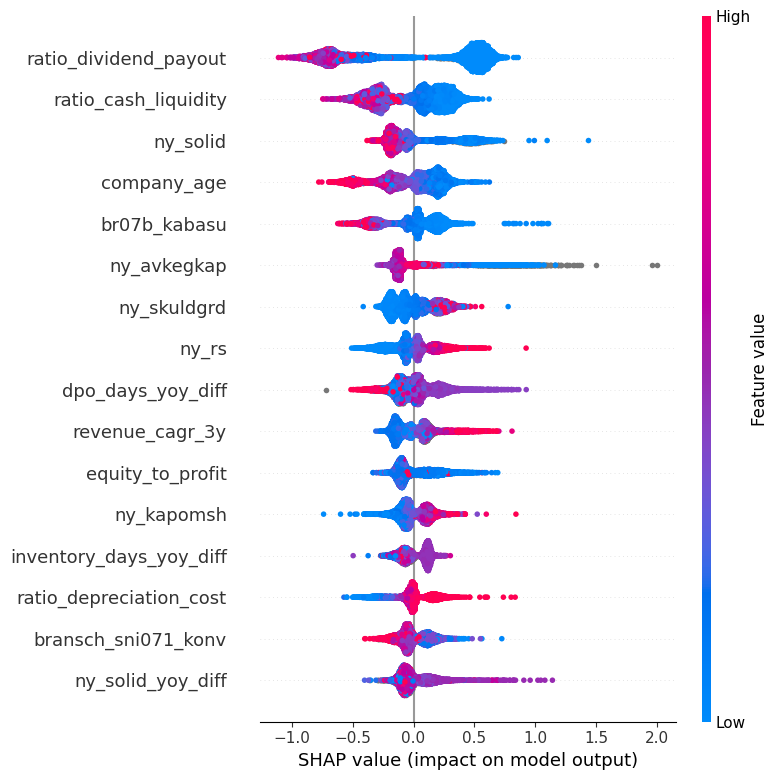

In [8]:
# SHAP analysis
from credit_risk_xai.modeling import get_shap_feature_importance, compute_shap_values
import shap

# 1. Compute SHAP-based feature importance
sample_size = min(10_000, len(X_val))
shap_importance = get_shap_feature_importance(model, X_val, max_samples=sample_size, top_n=None)

print("Top 117 Features (by SHAP):")
print(shap_importance.to_string(index=False))

# 2. Compare native importance vs SHAP
comparison = importance_df.merge(shap_importance, on='feature', how='inner')
comparison['importance_rank'] = comparison['importance'].rank(ascending=False)
comparison['shap_rank'] = comparison['mean_abs_shap'].rank(ascending=False)
comparison['rank_diff'] = abs(comparison['importance_rank'] - comparison['shap_rank'])
comparison = comparison.sort_values('rank_diff', ascending=False)

print("\n" + "="*80)
print("Features with Largest Rank Difference (Gain vs SHAP)")
print("="*80)
print(comparison[['feature', 'importance', 'importance_rank', 'mean_abs_shap', 'shap_rank', 'rank_diff']].head(15).to_string(index=False))

# 3. Generate SHAP summary plot
print(f"\nGenerating SHAP summary plot on {sample_size:,} samples...")
explainer, shap_values, X_sample = compute_shap_values(model, X_val, max_samples=sample_size)

# Handle binary classification
if isinstance(shap_values, list):
    shap_values = shap_values[1]

shap.summary_plot(shap_values, X_sample, max_display=16)

In [9]:
# Correlation analysis by financial statement source
from credit_risk_xai.modeling import (
    get_feature_correlations_by_source,
    find_high_correlations,
    plot_correlation_heatmap,
    summarize_within_group_correlations
)
from credit_risk_xai.config import FEATURE_GROUPS_BY_SOURCE

# 1. Summary of within-group correlations
print("=" * 90)
print("WITHIN-GROUP CORRELATION SUMMARY")
print("=" * 90)
group_summary = summarize_within_group_correlations(X_train, FEATURE_GROUPS_BY_SOURCE)
print(group_summary.to_string(index=False))

# 2. Compute correlations for each group
corr_by_source = get_feature_correlations_by_source(X_train, FEATURE_GROUPS_BY_SOURCE)

# 3. Find and display high correlations in each group
print("\n" + "=" * 90)
print("HIGH CORRELATIONS BY GROUP (|r| > 0.7)")
print("=" * 90)

for group_name in ["MACRO", "DERIVED_RATIOS", "WORKING_CAPITAL", "OPERATIONAL"]:
    if group_name not in corr_by_source:
        continue
    
    high_corrs = find_high_correlations(corr_by_source[group_name], threshold=0.7, top_n=50)
    
    if len(high_corrs) > 0:
        print(f"\n{group_name} - Top 50 Correlated Pairs:")
        print(high_corrs.to_string(index=False))
    else:
        print(f"\n{group_name} - No correlations above 0.7")

WITHIN-GROUP CORRELATION SUMMARY
           group  feature_count  mean_corr  median_corr  max_corr  min_corr  high_corr_pairs
INCOME_STATEMENT              6   0.067165     0.023906  0.331116  0.001623                0
        TEMPORAL              7   0.054952     0.003187  0.431071 -0.065501                0
     OPERATIONAL              5   0.014054     0.002203  0.125904 -0.047603                0
          TRENDS              9   0.009696    -0.000079  0.332934 -0.058063                0
  DERIVED_RATIOS             13  -0.000083     0.000037  0.729635 -0.696309                1
   BALANCE_SHEET              6  -0.000389     0.000028  0.069520 -0.131962                0
           MACRO              5  -0.017131    -0.001621  0.219511 -0.389037                0
 WORKING_CAPITAL              5  -0.019025     0.001137  0.052498 -0.304686                0

HIGH CORRELATIONS BY GROUP (|r| > 0.7)

MACRO - No correlations above 0.7

DERIVED_RATIOS - Top 50 Correlated Pairs:
       featu

In [10]:
# ============================================================================
# PHASE 1: FAST FEATURE ANALYSIS - Cell 1
# Low Variance Detection + High Multicollinearity Detection
# ============================================================================

from sklearn.feature_selection import VarianceThreshold
from credit_risk_xai.modeling import find_high_correlations

print("=" * 90)
print("FEATURE PRUNING ANALYSIS - PHASE 1: FAST ANALYSIS")
print("=" * 90)

# 1. LOW VARIANCE FEATURES
print("\n1. LOW VARIANCE DETECTION")
print("-" * 90)

def identify_low_variance_features(X, threshold=0.01):
    """Identify features with near-zero variance."""
    variances = X.var()
    low_var_features = variances[variances < threshold].sort_values()
    return pd.DataFrame({
        'feature': low_var_features.index,
        'variance': low_var_features.values
    })

low_var_df = identify_low_variance_features(X_train, threshold=0.01)
print(f"Features with variance < 0.01: {len(low_var_df)}")
if len(low_var_df) > 0:
    print("\nLow variance features:")
    print(low_var_df.to_string(index=False))
else:
    print("✓ No low variance features found")

# 2. HIGH MULTICOLLINEARITY (Feature-Feature)
print("\n" + "=" * 90)
print("2. MULTICOLLINEARITY DETECTION")
print("-" * 90)

# Compute full correlation matrix
corr_matrix = X_train.corr()

# Find high correlations at multiple thresholds
high_corr_90 = find_high_correlations(corr_matrix, threshold=0.90, top_n=None)
high_corr_85 = find_high_correlations(corr_matrix, threshold=0.85, top_n=None)

print(f"Feature pairs with |corr| > 0.90: {len(high_corr_90)}")
print(f"Feature pairs with |corr| > 0.85: {len(high_corr_85)}")

if len(high_corr_85) > 0:
    print("\nMost correlated feature pairs (|r| > 0.85):")
    print(high_corr_85.to_string(index=False))
else:
    print("✓ No highly correlated pairs above 0.85")

# 3. STORE FINDINGS
features_to_investigate = {
    'low_variance': low_var_df['feature'].tolist() if len(low_var_df) > 0 else [],
    'high_multicollinearity_85': list(set(
        high_corr_85['feature_1'].tolist() + high_corr_85['feature_2'].tolist()
    )) if len(high_corr_85) > 0 else [],
    'high_multicollinearity_90': list(set(
        high_corr_90['feature_1'].tolist() + high_corr_90['feature_2'].tolist()
    )) if len(high_corr_90) > 0 else []
}

print("\n" + "=" * 90)
print("SUMMARY - Features Flagged for Investigation")
print("=" * 90)
print(f"Low variance: {len(features_to_investigate['low_variance'])}")
print(f"High multicollinearity (>0.85): {len(features_to_investigate['high_multicollinearity_85'])}")
print(f"High multicollinearity (>0.90): {len(features_to_investigate['high_multicollinearity_90'])}")

FEATURE PRUNING ANALYSIS - PHASE 1: FAST ANALYSIS

1. LOW VARIANCE DETECTION
------------------------------------------------------------------------------------------
Features with variance < 0.01: 1

Low variance features:
                      feature  variance
years_since_last_credit_event       0.0

2. MULTICOLLINEARITY DETECTION
------------------------------------------------------------------------------------------


/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:51: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


Feature pairs with |corr| > 0.90: 0
Feature pairs with |corr| > 0.85: 0
✓ No highly correlated pairs above 0.85

SUMMARY - Features Flagged for Investigation
Low variance: 1
High multicollinearity (>0.85): 0
High multicollinearity (>0.90): 0


In [11]:
# ============================================================================
# PHASE 1: FAST FEATURE ANALYSIS - Cell 2
# Consolidate All Analyses into Master DataFrame
# ============================================================================

from credit_risk_xai.modeling.explain import analyze_correlation_with_target


print("=" * 90)
print("CONSOLIDATING ALL FEATURE ANALYSES")
print("=" * 90)

# Merge all importance metrics we already have
target_corr = analyze_correlation_with_target(X_train, y_train, method='pearson', top_n=50)

master_df = (
    importance_df  # tree-based (from earlier cell)
    .merge(shap_importance[['feature', 'mean_abs_shap']], on='feature', how='left')
    .merge(target_corr[['feature', 'correlation']], on='feature', how='left')
)

# Rename columns for clarity
master_df = master_df.rename(columns={
    'importance': 'tree_importance',
    'mean_abs_shap': 'shap_importance',
    'correlation': 'target_corr'
})

# Add variance
master_df['variance'] = master_df['feature'].apply(lambda f: X_train[f].var())

# Add flags for each removal criterion
master_df['is_low_variance'] = master_df['feature'].isin(features_to_investigate.get('low_variance', []))
master_df['is_multicollinear_85'] = master_df['feature'].isin(features_to_investigate.get('high_multicollinearity_85', []))
master_df['is_multicollinear_90'] = master_df['feature'].isin(features_to_investigate.get('high_multicollinearity_90', []))

# Identify low importance features (bottom 20% in both SHAP and tree importance)
shap_threshold_20 = master_df['shap_importance'].quantile(0.20)
tree_threshold_20 = master_df['tree_importance'].quantile(0.20)

master_df['is_low_shap'] = master_df['shap_importance'] < shap_threshold_20
master_df['is_low_tree'] = master_df['tree_importance'] < tree_threshold_20
master_df['is_low_both'] = master_df['is_low_shap'] & master_df['is_low_tree']

# Count "red flags" for each feature
flag_cols = ['is_low_variance', 'is_multicollinear_85', 'is_low_shap', 'is_low_tree']
master_df['red_flag_count'] = master_df[flag_cols].sum(axis=1)

# Sort by red flags (most problematic first)
master_df = master_df.sort_values('red_flag_count', ascending=False)

# Display summary
print(f"\nTotal features analyzed: {len(master_df)}")
print(f"Features with 3+ red flags: {(master_df['red_flag_count'] >= 3).sum()}")
print(f"Features with 2+ red flags: {(master_df['red_flag_count'] >= 2).sum()}")
print(f"Features with 1+ red flags: {(master_df['red_flag_count'] >= 1).sum()}")

print("\n" + "-" * 90)
print("Top 20 features with most red flags:")
print("-" * 90)
display_cols = ['feature', 'tree_importance', 'shap_importance', 'target_corr', 'variance', 'red_flag_count']
print(master_df[display_cols].head(20).to_string(index=False))

# Save for manual review
master_df.to_csv('feature_analysis_master.csv', index=False)
print(f"\n✓ Saved master analysis to: feature_analysis_master.csv")

print("\n" + "=" * 90)
print("RED FLAG BREAKDOWN")
print("=" * 90)
print(f"Low variance (<0.01): {master_df['is_low_variance'].sum()}")
print(f"Multicollinear (>0.85): {master_df['is_multicollinear_85'].sum()}")
print(f"Low SHAP (bottom 20%): {master_df['is_low_shap'].sum()}")
print(f"Low tree importance (bottom 20%): {master_df['is_low_tree'].sum()}")
print(f"Low in BOTH importance metrics: {master_df['is_low_both'].sum()}")

CONSOLIDATING ALL FEATURE ANALYSES

Total features analyzed: 58
Features with 3+ red flags: 0
Features with 2+ red flags: 7
Features with 1+ red flags: 18

------------------------------------------------------------------------------------------
Top 20 features with most red flags:
------------------------------------------------------------------------------------------
                      feature  tree_importance  shap_importance  target_corr     variance  red_flag_count
                   gdp_growth       849.930001         0.009183    -0.009849 5.138026e+00               2
           interest_avg_short      1476.345802         0.014299     0.006083 1.179208e+00               2
               inventory_days      1929.607568         0.019640     0.001154 3.602285e+07               2
                rr07_rorresul      1899.785954         0.019542    -0.027379 1.950214e+08               2
                   unemp_rate      1505.023898         0.020347    -0.010764 6.355752e-01      

/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:134: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:134: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/_core/_methods.py:134: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-risk-xai-thesis/.venv/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3065: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/vilhelmkarlin/Code/HHS/BE451_Thesis/credit-ris

In [12]:
# ============================================================================
# PHASE 1: FAST FEATURE ANALYSIS - Cell 3
# Resolve Multicollinearity Pairs - Keep Feature with Higher SHAP
# ============================================================================

print("=" * 90)
print("RESOLVING MULTICOLLINEARITY PAIRS")
print("=" * 90)

def resolve_multicollinearity_pairs(corr_pairs_df, master_df, strategy='shap'):
    """
    For each highly correlated pair, keep the better feature.
    
    Args:
        corr_pairs_df: DataFrame with columns ['feature_1', 'feature_2', 'correlation']
        master_df: Master feature analysis DataFrame
        strategy: 'shap', 'tree', or 'target_corr'
    
    Returns:
        List of features to drop
    """
    if len(corr_pairs_df) == 0:
        return []
    
    features_to_drop = []
    importance_col = {
        'shap': 'shap_importance',
        'tree': 'tree_importance',
        'target_corr': 'target_corr'
    }[strategy]
    
    for idx, row in corr_pairs_df.iterrows():
        feat1, feat2 = row['feature_1'], row['feature_2']
        
        # Skip if already marked for removal
        if feat1 in features_to_drop or feat2 in features_to_drop:
            continue
        
        # Get metrics for both
        metrics1 = master_df[master_df['feature'] == feat1].iloc[0]
        metrics2 = master_df[master_df['feature'] == feat2].iloc[0]
        
        # Decision: keep feature with higher importance
        val1 = metrics1[importance_col]
        val2 = metrics2[importance_col]
        
        if pd.isna(val1):
            val1 = 0
        if pd.isna(val2):
            val2 = 0
        
        if val1 >= val2:
            features_to_drop.append(feat2)
            print(f"Drop '{feat2}' (keep '{feat1}') | {importance_col}: {val2:.6f} vs {val1:.6f} | corr: {row['correlation']:.3f}")
        else:
            features_to_drop.append(feat1)
            print(f"Drop '{feat1}' (keep '{feat2}') | {importance_col}: {val1:.6f} vs {val2:.6f} | corr: {row['correlation']:.3f}")
    
    return features_to_drop

# Resolve multicollinearity using SHAP importance (as per user preference)
print(f"\nResolving {len(high_corr_85)} highly correlated pairs (|r| > 0.85)...")
print("Strategy: Keep feature with HIGHER SHAP importance")
print("-" * 90)

multicollinearity_drops = resolve_multicollinearity_pairs(
    high_corr_85, 
    master_df, 
    strategy='shap'
)

print("\n" + "=" * 90)
print(f"✓ Resolved {len(high_corr_85)} pairs → {len(multicollinearity_drops)} features to drop")
print("=" * 90)

RESOLVING MULTICOLLINEARITY PAIRS

Resolving 0 highly correlated pairs (|r| > 0.85)...
Strategy: Keep feature with HIGHER SHAP importance
------------------------------------------------------------------------------------------

✓ Resolved 0 pairs → 0 features to drop


In [13]:
# ============================================================================
# PHASE 2: PROGRESSIVE PRUNING - Cell 4
# Round 1: Conservative Pruning
# ============================================================================

print("=" * 90)
print("PHASE 2: PROGRESSIVE FEATURE PRUNING")
print("=" * 90)
print("\nROUND 1: CONSERVATIVE PRUNING")
print("-" * 90)
print("Removal criteria:")
print("  - Near-zero variance features")
print("  - One feature from each highly correlated pair (|r| > 0.85)")
print("  - Features with 3+ red flags")
print("-" * 90)

# Build conservative removal list
automatic_removal = master_df[master_df['red_flag_count'] >= 3]['feature'].tolist()

conservative_removal_list = list(set(
    features_to_investigate.get('low_variance', []) +
    multicollinearity_drops +
    automatic_removal
))

print(f"\nRemoval breakdown:")
print(f"  - Low variance: {len(features_to_investigate.get('low_variance', []))}")
print(f"  - Multicollinearity: {len(multicollinearity_drops)}")
print(f"  - Multiple red flags (3+): {len(automatic_removal)}")
print(f"\nTotal features to remove: {len(conservative_removal_list)}")
print(f"Features remaining: {X_train.shape[1] - len(conservative_removal_list)}")
print(f"Reduction: {100 * len(conservative_removal_list) / X_train.shape[1]:.1f}%")

# Create pruned dataset
features_conservative = [f for f in X_train.columns if f not in conservative_removal_list]
X_train_conservative = X_train[features_conservative]
X_val_conservative = X_val[features_conservative]

# Retrain model with same hyperparameters
print("\n" + "-" * 90)
print("Retraining model with conservative feature set...")
print("-" * 90)

lgbm_conservative = lgb.LGBMClassifier(**DEFAULT_PARAMS)
lgbm_conservative.fit(
    X_train_conservative, y_train,
    eval_set=[(X_val_conservative, y_val)],
    eval_metric='logloss',
    callbacks=[lgb.log_evaluation(100), lgb.early_stopping(50)]
)

# Predictions
y_pred_proba_conservative = lgbm_conservative.predict_proba(X_val_conservative)[:, 1]
y_pred_conservative = (y_pred_proba_conservative >= 0.5).astype(int)

# Evaluate
auc_conservative = roc_auc_score(y_val, y_pred_proba_conservative)
pr_auc_conservative = average_precision_score(y_val, y_pred_proba_conservative)

print("\n" + "=" * 90)
print("CONSERVATIVE MODEL PERFORMANCE")
print("=" * 90)
print(f"ROC-AUC:  {auc_conservative:.6f} (baseline: {auc:.6f}, Δ: {auc_conservative - auc:+.6f})")
print(f"PR-AUC:   {pr_auc_conservative:.6f} (baseline: {pr_auc:.6f}, Δ: {pr_auc_conservative - pr_auc:+.6f})")
print(f"\nFeatures: {len(features_conservative)} (from {X_train.shape[1]})")
print(f"Reduction: {100 * len(conservative_removal_list) / X_train.shape[1]:.1f}%")

print("\nClassification Report:")
print(classification_report(y_val, y_pred_conservative))

PHASE 2: PROGRESSIVE FEATURE PRUNING

ROUND 1: CONSERVATIVE PRUNING
------------------------------------------------------------------------------------------
Removal criteria:
  - Near-zero variance features
  - One feature from each highly correlated pair (|r| > 0.85)
  - Features with 3+ red flags
------------------------------------------------------------------------------------------

Removal breakdown:
  - Low variance: 1
  - Multicollinearity: 0
  - Multiple red flags (3+): 0

Total features to remove: 1
Features remaining: 57
Reduction: 1.7%

------------------------------------------------------------------------------------------
Retraining model with conservative feature set...
------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.0473682
[200]	valid_0's binary_logloss: 0.0464581
[300]	valid_0's binary_logloss: 0.0462894
[400]	valid_0's binary_

In [14]:
# ============================================================================
# PHASE 2: PROGRESSIVE PRUNING - Cell 5
# Round 2: Moderate Pruning
# ============================================================================

print("=" * 90)
print("ROUND 2: MODERATE PRUNING")
print("-" * 90)
print("Additional removal criteria:")
print("  - Features in bottom 20% of BOTH SHAP and tree importance")
print("-" * 90)

# Add features that are low in both importance metrics
low_both_features = master_df[master_df['is_low_both']]['feature'].tolist()

moderate_removal_list = list(set(
    conservative_removal_list +
    low_both_features
))

print(f"\nAdding {len(low_both_features)} features with low importance in both metrics")
print(f"Total features to remove: {len(moderate_removal_list)}")
print(f"Features remaining: {X_train.shape[1] - len(moderate_removal_list)}")
print(f"Reduction: {100 * len(moderate_removal_list) / X_train.shape[1]:.1f}%")

# Create moderate pruned dataset
features_moderate = [f for f in X_train.columns if f not in moderate_removal_list]
X_train_moderate = X_train[features_moderate]
X_val_moderate = X_val[features_moderate]

print("\n" + "-" * 90)
print("Retraining model with moderate feature set...")
print("-" * 90)

lgbm_moderate = lgb.LGBMClassifier(**DEFAULT_PARAMS)
lgbm_moderate.fit(
    X_train_moderate, y_train,
    eval_set=[(X_val_moderate, y_val)],
    eval_metric='logloss',
    callbacks=[lgb.log_evaluation(100), lgb.early_stopping(50)]
)

# Predictions
y_pred_proba_moderate = lgbm_moderate.predict_proba(X_val_moderate)[:, 1]
y_pred_moderate = (y_pred_proba_moderate >= 0.5).astype(int)

# Evaluate
auc_moderate = roc_auc_score(y_val, y_pred_proba_moderate)
pr_auc_moderate = average_precision_score(y_val, y_pred_proba_moderate)

print("\n" + "=" * 90)
print("MODERATE MODEL PERFORMANCE")
print("=" * 90)
print(f"ROC-AUC:  {auc_moderate:.6f} (baseline: {auc:.6f}, Δ: {auc_moderate - auc:+.6f})")
print(f"PR-AUC:   {pr_auc_moderate:.6f} (baseline: {pr_auc:.6f}, Δ: {pr_auc_moderate - pr_auc:+.6f})")
print(f"\nFeatures: {len(features_moderate)} (from {X_train.shape[1]})")
print(f"Reduction: {100 * len(moderate_removal_list) / X_train.shape[1]:.1f}%")

print("\nClassification Report:")
print(classification_report(y_val, y_pred_moderate))

ROUND 2: MODERATE PRUNING
------------------------------------------------------------------------------------------
Additional removal criteria:
  - Features in bottom 20% of BOTH SHAP and tree importance
------------------------------------------------------------------------------------------

Adding 7 features with low importance in both metrics
Total features to remove: 8
Features remaining: 50
Reduction: 13.8%

------------------------------------------------------------------------------------------
Retraining model with moderate feature set...
------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.0475156
[200]	valid_0's binary_logloss: 0.0465658
[300]	valid_0's binary_logloss: 0.0464565
[400]	valid_0's binary_logloss: 0.0463587
[500]	valid_0's binary_logloss: 0.0464062
Early stopping, best iteration is:
[456]	valid_0's binary_logloss: 0.0463128

MO

In [15]:
# ============================================================================
# PHASE 2: PROGRESSIVE PRUNING - Cell 6
# Round 3: Top-K Pruning Tests (Aggressive)
# ============================================================================

print("=" * 90)
print("ROUND 3: TOP-K FEATURE SELECTION (AGGRESSIVE)")
print("-" * 90)
print("Testing different feature set sizes by keeping only top-K features by SHAP importance")
print("-" * 90)

# Sort features by SHAP importance
shap_ranked = master_df.sort_values('shap_importance', ascending=False)

# Store results for different K values
topk_results = {}

for top_k in [60, 50, 40, 30]:
    print(f"\n{'='*90}")
    print(f"Testing TOP-{top_k} features by SHAP importance")
    print('-'*90)
    
    # Select top K features
    features_topk = shap_ranked.head(top_k)['feature'].tolist()
    
    X_train_topk = X_train[features_topk]
    X_val_topk = X_val[features_topk]
    
    # Train model (silent mode)
    lgbm_topk = lgb.LGBMClassifier(**DEFAULT_PARAMS)
    lgbm_topk.fit(
        X_train_topk, y_train,
        eval_set=[(X_val_topk, y_val)],
        eval_metric='logloss',
        callbacks=[lgb.log_evaluation(0), lgb.early_stopping(50)]  # Silent
    )
    
    # Evaluate
    y_pred_proba_topk = lgbm_topk.predict_proba(X_val_topk)[:, 1]
    y_pred_topk = (y_pred_proba_topk >= 0.5).astype(int)
    
    auc_topk = roc_auc_score(y_val, y_pred_proba_topk)
    pr_auc_topk = average_precision_score(y_val, y_pred_proba_topk)
    
    # Store results
    topk_results[f'top_{top_k}'] = {
        'model': lgbm_topk,
        'features': features_topk,
        'X_train': X_train_topk,
        'X_val': X_val_topk,
        'y_pred_proba': y_pred_proba_topk,
        'y_pred': y_pred_topk,
        'auc': auc_topk,
        'pr_auc': pr_auc_topk,
        'num_features': top_k
    }
    
    print(f"ROC-AUC:  {auc_topk:.6f} (Δ from baseline: {auc_topk - auc:+.6f})")
    print(f"PR-AUC:   {pr_auc_topk:.6f} (Δ from baseline: {pr_auc_topk - pr_auc:+.6f})")
    print(f"Features: {top_k} ({100 * (X_train.shape[1] - top_k) / X_train.shape[1]:.1f}% reduction)")

print("\n" + "=" * 90)
print("✓ Top-K testing complete")
print("=" * 90)

ROUND 3: TOP-K FEATURE SELECTION (AGGRESSIVE)
------------------------------------------------------------------------------------------
Testing different feature set sizes by keeping only top-K features by SHAP importance
------------------------------------------------------------------------------------------

Testing TOP-60 features by SHAP importance
------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[267]	valid_0's binary_logloss: 0.0459199
ROC-AUC:  0.952041 (Δ from baseline: +0.000373)
PR-AUC:   0.650282 (Δ from baseline: +0.000772)
Features: 60 (-3.4% reduction)

Testing TOP-50 features by SHAP importance
------------------------------------------------------------------------------------------
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[412]	valid_0's binary_logloss: 0.0459471
ROC-AUC:  0.9

COMPREHENSIVE PERFORMANCE COMPARISON

               Approach  Num_Features  ROC_AUC   PR_AUC  Feature_Reduction_%  AUC_Delta  PR_AUC_Delta
Baseline (105 features)            58 0.951668 0.649510             0.000000   0.000000      0.000000
   Conservative Pruning            57 0.951320 0.647652             1.724138  -0.000348     -0.001858
       Moderate Pruning            50 0.951573 0.645570            13.793103  -0.000095     -0.003941
            Top-50 SHAP            50 0.952394 0.648897            13.793103   0.000726     -0.000614
            Top-40 SHAP            40 0.951688 0.644890            31.034483   0.000020     -0.004620
            Top-30 SHAP            30 0.925316 0.511616            48.275862  -0.026352     -0.137894


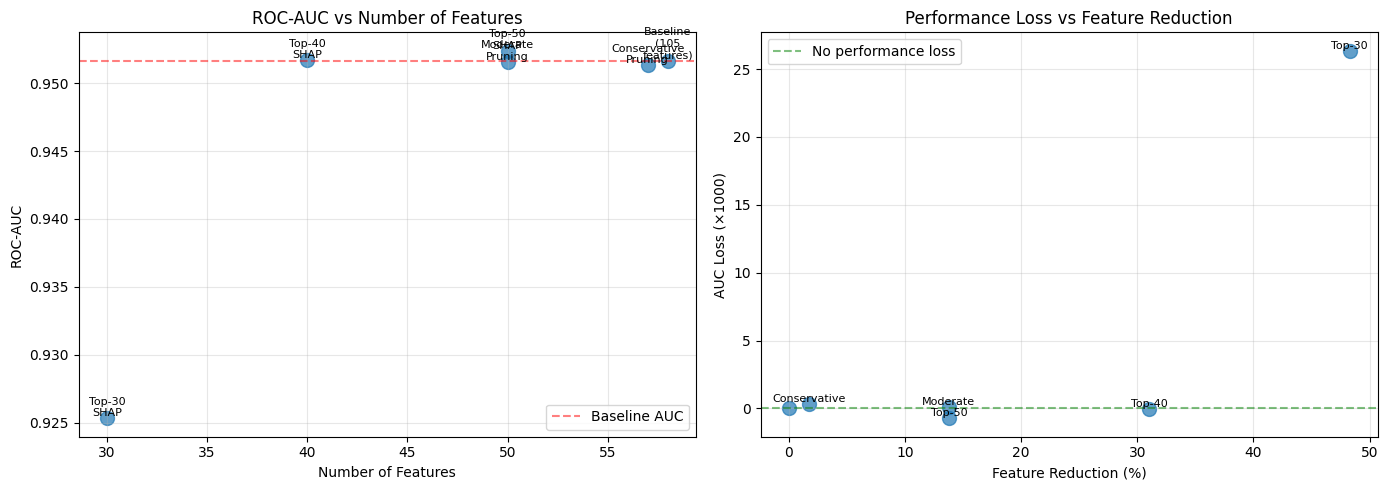


RECOMMENDATION & DECISION GUIDANCE


IndexError: single positional indexer is out-of-bounds

In [16]:
# ============================================================================
# PHASE 2: PROGRESSIVE PRUNING - Cell 7
# Performance Comparison & Decision Point
# ============================================================================

print("=" * 90)
print("COMPREHENSIVE PERFORMANCE COMPARISON")
print("=" * 90)

# Compile all results
comparison_data = {
    'Approach': [
        'Baseline (105 features)',
        'Conservative Pruning',
        'Moderate Pruning',
        'Top-50 SHAP',
        'Top-40 SHAP',
        'Top-30 SHAP'
    ],
    'Num_Features': [
        X_train.shape[1],
        len(features_conservative),
        len(features_moderate),
        50, 40, 30
    ],
    'ROC_AUC': [
        auc,
        auc_conservative,
        auc_moderate,
        topk_results['top_50']['auc'],
        topk_results['top_40']['auc'],
        topk_results['top_30']['auc']
    ],
    'PR_AUC': [
        pr_auc,
        pr_auc_conservative,
        pr_auc_moderate,
        topk_results['top_50']['pr_auc'],
        topk_results['top_40']['pr_auc'],
        topk_results['top_30']['pr_auc']
    ]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df['Feature_Reduction_%'] = 100 * (X_train.shape[1] - comparison_df['Num_Features']) / X_train.shape[1]
comparison_df['AUC_Delta'] = comparison_df['ROC_AUC'] - auc
comparison_df['PR_AUC_Delta'] = comparison_df['PR_AUC'] - pr_auc

print("\n" + comparison_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: AUC vs Feature Count
axes[0].scatter(comparison_df['Num_Features'], comparison_df['ROC_AUC'], s=100, alpha=0.7)
for idx, row in comparison_df.iterrows():
    axes[0].annotate(
        row['Approach'].replace(' ', '\n'), 
        (row['Num_Features'], row['ROC_AUC']),
        fontsize=8, ha='center', va='bottom'
    )
axes[0].axhline(y=auc, color='red', linestyle='--', alpha=0.5, label='Baseline AUC')
axes[0].set_xlabel('Number of Features')
axes[0].set_ylabel('ROC-AUC')
axes[0].set_title('ROC-AUC vs Number of Features')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Plot 2: Feature Reduction vs Performance Loss
axes[1].scatter(comparison_df['Feature_Reduction_%'], -comparison_df['AUC_Delta'] * 1000, s=100, alpha=0.7)
for idx, row in comparison_df.iterrows():
    if idx > 0:  # Skip baseline
        axes[1].annotate(
            row['Approach'].split()[0], 
            (row['Feature_Reduction_%'], -row['AUC_Delta'] * 1000),
            fontsize=8, ha='center', va='bottom'
        )
axes[1].axhline(y=0, color='green', linestyle='--', alpha=0.5, label='No performance loss')
axes[1].set_xlabel('Feature Reduction (%)')
axes[1].set_ylabel('AUC Loss (×1000)')
axes[1].set_title('Performance Loss vs Feature Reduction')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# Decision guidance
print("\n" + "=" * 90)
print("RECOMMENDATION & DECISION GUIDANCE")
print("=" * 90)

# Find best tradeoffs
best_auc = comparison_df.iloc[comparison_df['ROC_AUC'].idxmax()]
best_reduction = comparison_df[comparison_df['Feature_Reduction_%'] > 20].iloc[
    comparison_df[comparison_df['Feature_Reduction_%'] > 20]['AUC_Delta'].idxmax()
]

print(f"\n✓ Best AUC: {best_auc['Approach']} ({best_auc['ROC_AUC']:.6f})")
print(f"✓ Best balance (>20% reduction): {best_reduction['Approach']}")
print(f"  - {best_reduction['Num_Features']} features ({best_reduction['Feature_Reduction_%']:.1f}% reduction)")
print(f"  - AUC: {best_reduction['ROC_AUC']:.6f} (Δ: {best_reduction['AUC_Delta']:+.6f})")

print("\n" + "-" * 90)
print("Next step: Choose your preferred approach and run the final analysis cells")
print("Recommendation: Conservative or Moderate if AUC loss < 0.001")
print("               Top-K if you need maximum interpretability and AUC loss is acceptable")
print("=" * 90)

In [17]:
moderate_removal_list

['years_since_last_credit_event',
 'unemp_rate',
 'ser_laen',
 'interest_avg_short',
 'rr07_rorresul',
 'inventory_days',
 'gdp_growth',
 'rr01_ntoms']

In [ ]:
# ============================================================================
# PHASE 3: FINAL MODEL ANALYSIS - Cell 8
# Select Final Model & Re-analyze Feature Set
# ============================================================================

print("=" * 90)
print("PHASE 3: FINAL MODEL SELECTION & ANALYSIS")
print("=" * 90)

# USER DECISION: Choose which model to use as final
# Options: 'conservative', 'moderate', 'top_50', 'top_40', 'top_30'
FINAL_MODEL_CHOICE = 'conservative'  # ← CHANGE THIS based on comparison results

print(f"\nSelected approach: {FINAL_MODEL_CHOICE.upper()}")
print("-" * 90)

# Map choice to results
model_map = {
    'conservative': {
        'model': lgbm_conservative,
        'features': features_conservative,
        'X_train': X_train_conservative,
        'X_val': X_val_conservative,
        'y_pred_proba': y_pred_proba_conservative,
        'removal_list': conservative_removal_list,
        'auc': auc_conservative,
        'pr_auc': pr_auc_conservative
    },
    'moderate': {
        'model': lgbm_moderate,
        'features': features_moderate,
        'X_train': X_train_moderate,
        'X_val': X_val_moderate,
        'y_pred_proba': y_pred_proba_moderate,
        'removal_list': moderate_removal_list,
        'auc': auc_moderate,
        'pr_auc': pr_auc_moderate
    },
    'top_50': topk_results['top_50'],
    'top_40': topk_results['top_40'],
    'top_30': topk_results['top_30']
}

final_model_data = model_map[FINAL_MODEL_CHOICE]
final_model = final_model_data['model']
final_features = final_model_data['features']
final_X_train = final_model_data['X_train']
final_X_val = final_model_data['X_val']
final_y_pred_proba = final_model_data['y_pred_proba']

print(f"Final feature count: {len(final_features)}")
print(f"Reduction: {100 * (X_train.shape[1] - len(final_features)) / X_train.shape[1]:.1f}%")
print(f"ROC-AUC: {final_model_data['auc']:.6f}")
print(f"PR-AUC: {final_model_data['pr_auc']:.6f}")

# 1. FEATURE IMPORTANCE FOR FINAL MODEL
print("\n" + "=" * 90)
print("FEATURE IMPORTANCE - FINAL MODEL")
print("=" * 90)

final_importance_df = pd.DataFrame({
    'feature': final_model.feature_name_,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 30 features:")
print(final_importance_df.head(30).to_string(index=False))

# Plot top features
from credit_risk_xai.modeling import plot_feature_importance
plot_feature_importance(final_importance_df, top_n=25, title=f"Top 25 Features - {FINAL_MODEL_CHOICE.upper()} Model")

# Importance concentration
top10_importance = final_importance_df.head(10)['importance'].sum() / final_importance_df['importance'].sum()
top20_importance = final_importance_df.head(20)['importance'].sum() / final_importance_df['importance'].sum()

print(f"\n✓ Top 10 features account for {top10_importance * 100:.1f}% of total importance")
print(f"✓ Top 20 features account for {top20_importance * 100:.1f}% of total importance")

# 2. RE-CHECK CORRELATION ANALYSIS
print("\n" + "=" * 90)
print("CORRELATION CHECK - FINAL MODEL")
print("=" * 90)

# Re-check feature-feature correlation in final set
final_corr_matrix = final_X_train.corr()
remaining_high_corr = find_high_correlations(final_corr_matrix, threshold=0.80, top_n=None)

print(f"Remaining feature pairs with |corr| > 0.80: {len(remaining_high_corr)}")
if len(remaining_high_corr) > 0:
    print("\n⚠️  WARNING: Still have correlated features:")
    print(remaining_high_corr.head(10).to_string(index=False))
else:
    print("✓ No highly correlated feature pairs remain!")

# 3. FEATURE GROUP BREAKDOWN
print("\n" + "=" * 90)
print("FEATURE GROUP ANALYSIS - FINAL MODEL")
print("=" * 90)

from credit_risk_xai.config import FEATURE_GROUPS_BY_SOURCE

# Count features by group in final set
group_counts = {}
for group_name, group_features in FEATURE_GROUPS_BY_SOURCE.items():
    count = len([f for f in final_features if f in group_features])
    total = len(group_features)
    group_counts[group_name] = {
        'kept': count,
        'total': total,
        'retention_%': 100 * count / total if total > 0 else 0
    }

group_breakdown = pd.DataFrame(group_counts).T.reset_index()
group_breakdown.columns = ['Group', 'Kept', 'Total', 'Retention_%']
group_breakdown = group_breakdown.sort_values('Kept', ascending=False)

print(group_breakdown.to_string(index=False))

PHASE 3: FINAL MODEL SELECTION & ANALYSIS

Selected approach: CONSERVATIVE
------------------------------------------------------------------------------------------
Final feature count: 68
Reduction: 17.1%
ROC-AUC: 0.961386
PR-AUC: 0.682287

FEATURE IMPORTANCE - FINAL MODEL

Top 30 features:
                        feature  importance
ratio_ebit_interest_cov_yoy_pct         216
                       dpo_days         205
                        ny_omsf         192
          rr07_rorresul_yoy_pct         187
              dpo_days_yoy_diff         178
            bransch_sni071_konv         176
                          ny_rs         167
   ratio_cash_liquidity_yoy_pct         164
             rr01_ntoms_yoy_abs         150
                    ny_avkegkap         146
              dso_days_yoy_diff         144
           ratio_cash_liquidity         141
                      br10_eksu         138
                revenue_cagr_3y         137
              ny_solid_yoy_diff         134
  

TypeError: plot_feature_importance() got an unexpected keyword argument 'title'

In [ ]:
# ============================================================================
# PHASE 3: FINAL MODEL ANALYSIS - Cell 9
# Calibration Curves - Baseline vs Final Model
# ============================================================================

print("=" * 90)
print("CALIBRATION ANALYSIS - BASELINE vs FINAL MODEL")
print("=" * 90)

# Plot calibration curves for comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Baseline model calibration
from sklearn.calibration import calibration_curve

fraction_baseline, mean_pred_baseline = calibration_curve(
    y_val, y_pred_proba, n_bins=100, strategy='quantile'
)
ece_baseline = np.mean(np.abs(fraction_baseline - mean_pred_baseline))

axes[0].plot(mean_pred_baseline, fraction_baseline, "s-", label="Baseline Model", linewidth=2)
axes[0].plot([0, 1], [0, 1], "k--", label="Perfect calibration", alpha=0.5)
axes[0].set_xlabel("Mean predicted probability")
axes[0].set_ylabel("Fraction of positives")
axes[0].set_title(f"Baseline Model (105 features)\nECE: {ece_baseline:.4f}")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Final model calibration
fraction_final, mean_pred_final = calibration_curve(
    y_val, final_y_pred_proba, n_bins=100, strategy='quantile'
)
ece_final = np.mean(np.abs(fraction_final - mean_pred_final))

axes[1].plot(mean_pred_final, fraction_final, "s-", label=f"{FINAL_MODEL_CHOICE.upper()} Model", linewidth=2, color='orange')
axes[1].plot([0, 1], [0, 1], "k--", label="Perfect calibration", alpha=0.5)
axes[1].set_xlabel("Mean predicted probability")
axes[1].set_ylabel("Fraction of positives")
axes[1].set_title(f"{FINAL_MODEL_CHOICE.upper()} Model ({len(final_features)} features)\nECE: {ece_final:.4f}")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Comparison
print("\n" + "=" * 90)
print("CALIBRATION COMPARISON")
print("=" * 90)
print(f"Baseline ECE:  {ece_baseline:.4f}")
print(f"Final ECE:     {ece_final:.4f}")
print(f"Δ ECE:         {ece_final - ece_baseline:+.4f}")

if abs(ece_final - ece_baseline) < 0.001:
    print("\n✓ Calibration is virtually unchanged")
elif ece_final < ece_baseline:
    print("\n✓ Calibration improved after feature pruning")
else:
    print("\n⚠️  Calibration slightly worse (may need recalibration)")

# Side-by-side overlay
plt.figure(figsize=(10, 7))
plt.plot(mean_pred_baseline, fraction_baseline, "s-", label=f"Baseline (ECE: {ece_baseline:.4f})", linewidth=2, alpha=0.7)
plt.plot(mean_pred_final, fraction_final, "o-", label=f"{FINAL_MODEL_CHOICE.upper()} (ECE: {ece_final:.4f})", linewidth=2, alpha=0.7)
plt.plot([0, 1], [0, 1], "k--", label="Perfect calibration", alpha=0.5)
plt.xlabel("Mean predicted probability", fontsize=12)
plt.ylabel("Fraction of positives", fontsize=12)
plt.title("Calibration Curve Comparison", fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# ============================================================================
# PHASE 3: FINAL MODEL ANALYSIS - Cell 10
# Export Results & Documentation
# ============================================================================

print("=" * 90)
print("EXPORTING RESULTS & DOCUMENTATION")
print("=" * 90)

# 1. CREATE FEATURE REMOVAL REPORT
print("\n1. Creating feature removal report...")
print("-" * 90)

# Identify which features were removed and why
if FINAL_MODEL_CHOICE in ['conservative', 'moderate']:
    removal_list = final_model_data['removal_list']
    
    removal_report = []
    for feat in removal_list:
        feat_info = master_df[master_df['feature'] == feat].iloc[0]
        
        reasons = []
        if feat_info['is_low_variance']:
            reasons.append('Low variance')
        if feat_info['is_multicollinear_85']:
            reasons.append('Multicollinear (|r|>0.85)')
        if feat_info['is_low_shap']:
            reasons.append('Low SHAP importance (bottom 20%)')
        if feat_info['is_low_tree']:
            reasons.append('Low tree importance (bottom 20%)')
        
        removal_report.append({
            'feature': feat,
            'removal_reason': '; '.join(reasons) if reasons else 'Part of correlated pair',
            'tree_importance': feat_info['tree_importance'],
            'shap_importance': feat_info['shap_importance'],
            'target_corr': feat_info['target_corr'],
            'variance': feat_info['variance'],
            'red_flag_count': feat_info['red_flag_count']
        })
    
    removal_report_df = pd.DataFrame(removal_report).sort_values('red_flag_count', ascending=False)
    removal_report_df.to_csv('feature_removal_report.csv', index=False)
    print(f"✓ Saved feature removal report: feature_removal_report.csv ({len(removal_report_df)} features)")

# 2. EXPORT FINAL FEATURE LIST
print("\n2. Exporting final feature list...")
print("-" * 90)

final_features_df = pd.DataFrame({
    'feature': sorted(final_features),
    'feature_type': [final_X_train[f].dtype for f in sorted(final_features)]
})
final_features_df.to_csv('final_feature_list.csv', index=False)
print(f"✓ Saved final feature list: final_feature_list.csv ({len(final_features)} features)")

# Feature type breakdown
print("\nFeature type breakdown:")
print(final_features_df['feature_type'].value_counts().to_string())

# 3. EXPORT AS PYTHON CONSTANT
print("\n3. Exporting as Python constant...")
print("-" * 90)

with open('final_features.py', 'w') as f:
    f.write("# Auto-generated feature list after pruning\n")
    f.write(f"# Generated on: {pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"# Pruning approach: {FINAL_MODEL_CHOICE.upper()}\n")
    f.write(f"# Original features: {X_train.shape[1]}\n")
    f.write(f"# Final features: {len(final_features)}\n")
    f.write(f"# Reduction: {100 * (X_train.shape[1] - len(final_features)) / X_train.shape[1]:.1f}%\n")
    f.write(f"# ROC-AUC: {final_model_data['auc']:.6f}\n")
    f.write(f"# PR-AUC: {final_model_data['pr_auc']:.6f}\n\n")
    f.write("FINAL_FEATURES = [\n")
    for feat in sorted(final_features):
        f.write(f"    '{feat}',\n")
    f.write("]\n")

print("✓ Saved Python constant: final_features.py")

# 4. SUMMARY STATISTICS
print("\n" + "=" * 90)
print("FINAL SUMMARY")
print("=" * 90)

summary_stats = {
    'Metric': [
        'Original Features',
        'Final Features',
        'Features Removed',
        'Reduction %',
        '',
        'Baseline ROC-AUC',
        'Final ROC-AUC',
        'AUC Change',
        '',
        'Baseline PR-AUC',
        'Final PR-AUC',
        'PR-AUC Change',
        '',
        'Baseline ECE',
        'Final ECE',
        'ECE Change'
    ],
    'Value': [
        X_train.shape[1],
        len(final_features),
        X_train.shape[1] - len(final_features),
        f"{100 * (X_train.shape[1] - len(final_features)) / X_train.shape[1]:.1f}%",
        '',
        f"{auc:.6f}",
        f"{final_model_data['auc']:.6f}",
        f"{final_model_data['auc'] - auc:+.6f}",
        '',
        f"{pr_auc:.6f}",
        f"{final_model_data['pr_auc']:.6f}",
        f"{final_model_data['pr_auc'] - pr_auc:+.6f}",
        '',
        f"{ece_baseline:.4f}",
        f"{ece_final:.4f}",
        f"{ece_final - ece_baseline:+.4f}"
    ]
}

summary_df = pd.DataFrame(summary_stats)
print("\n" + summary_df.to_string(index=False))

# Save summary
summary_df.to_csv('feature_pruning_summary.csv', index=False)
print("\n✓ Saved summary: feature_pruning_summary.csv")

print("\n" + "=" * 90)
print("✓ FEATURE PRUNING COMPLETE!")
print("=" * 90)
print(f"\nApproach used: {FINAL_MODEL_CHOICE.upper()}")
print(f"Final model: {len(final_features)} features ({100 * (X_train.shape[1] - len(final_features)) / X_train.shape[1]:.1f}% reduction)")
print(f"Performance: AUC {final_model_data['auc']:.6f} (Δ {final_model_data['auc'] - auc:+.6f})")
print("\nGenerated files:")
print("  - feature_analysis_master.csv")
print("  - feature_removal_report.csv")
print("  - final_feature_list.csv")
print("  - final_features.py")
print("  - feature_pruning_summary.csv")
print("\n" + "=" * 90)

In [16]:
conservative_removal_list

['ratio_personnel_cost',
 'ratio_financial_cost',
 'inflation_yoy',
 'equity_to_sales',
 'dso_days',
 'br09_tillgsu',
 'ny_rormarg']